In [1]:
%matplotlib inline


Audio Feature Extractions
===================

``torchaudio`` implements feature extractions commonly used in the audio
domain. They are available in ``torchaudio.functional`` and
``torchaudio.transforms``.

``functional`` implements features as standalone functions.
They are stateless.

``transforms`` implements features as objects,
using implementations from ``functional`` and ``torch.nn.Module``. Because all
transforms are subclasses of ``torch.nn.Module``, they can be serialized
using TorchScript.

For the complete list of available features, please refer to the
documentation. In this tutorial, we will look into converting between the
time domain and frequency domain (``Spectrogram``, ``GriffinLim``,
``MelSpectrogram``).


In [2]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
# !pip install torchaudio librosa

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.10.0+cu111
0.10.0+cu111


Preparing data and utility functions (skip this section)
--------------------------------------------------------




In [3]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------

import os
import requests

import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display


_SAMPLE_DIR = "_sample_data"

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)


def _fetch_data():
  uri = [
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

Spectrogram
-----------

To get the frequency make-up of an audio signal as it varies with time,
you can use ``Spectrogram``.




Shape: (1, 513, 107)
Dtype: torch.float32
 - Max:     4000.533
 - Min:      0.000
 - Mean:     5.726
 - Std Dev: 70.301

tensor([[[7.8743e+00, 4.4462e+00, 5.6781e-01,  ..., 2.7694e+01,
          8.9546e+00, 4.1289e+00],
         [7.1094e+00, 3.2595e+00, 7.3520e-01,  ..., 1.7141e+01,
          4.4812e+00, 8.0840e-01],
         [3.8374e+00, 8.2490e-01, 3.0779e-01,  ..., 1.8502e+00,
          1.1777e-01, 1.2369e-01],
         ...,
         [3.4708e-07, 1.0604e-05, 1.2395e-05,  ..., 7.4090e-06,
          8.2063e-07, 1.0176e-05],
         [4.7173e-05, 4.4329e-07, 3.9444e-05,  ..., 3.0622e-05,
          3.9735e-07, 8.1572e-06],
         [1.3221e-04, 1.6440e-05, 7.2536e-05,  ..., 5.4662e-05,
          1.1663e-05, 2.5758e-06]]])



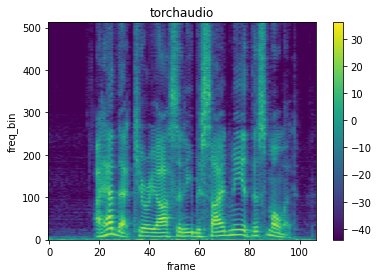

In [4]:
waveform, sample_rate = get_speech_sample()

n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

GriffinLim
----------

To recover a waveform from a spectrogram, you can use ``GriffinLim``.




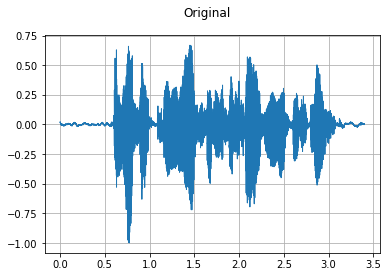

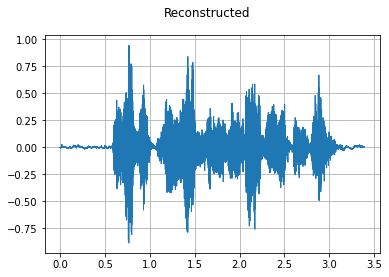

In [5]:
torch.random.manual_seed(0)
waveform, sample_rate = get_speech_sample()
plot_waveform(waveform, sample_rate, title="Original")
play_audio(waveform, sample_rate)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(waveform)

griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)
waveform = griffin_lim(spec)

plot_waveform(waveform, sample_rate, title="Reconstructed")
play_audio(waveform, sample_rate)

Mel Filter Bank
---------------

``torchaudio.functional.create_fb_matrix`` generates the filter bank
for converting frequency bins to mel-scale bins.

Since this function does not require input audio/features, there is no
equivalent transform in ``torchaudio.transforms``.




/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:518: UserWarning: The use of `create_fb_matrix` is now deprecated and will be removed in the 0.11 release. Please migrate your code to use `melscale_fbanks` instead. For more information, please refer to https://github.com/pytorch/audio/issues/1574.
  "The use of `create_fb_matrix` is now deprecated and will be removed in "


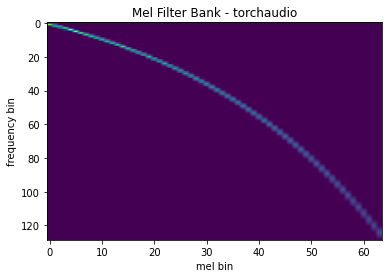

In [6]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.create_fb_matrix(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.,
    f_max=sample_rate/2.,
    sample_rate=sample_rate,
    norm='slaney'
)
plot_mel_fbank(mel_filters, "Mel Filter Bank - torchaudio")

Comparison against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~~

For reference, here is the equivalent way to get the mel filter bank
with ``librosa``.




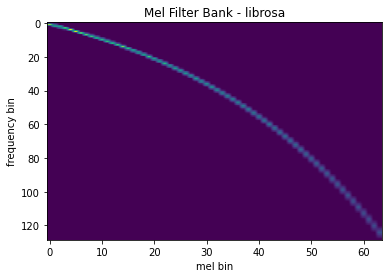

Mean Square Difference:  3.795462323290159e-17


In [7]:
mel_filters_librosa = librosa.filters.mel(
    sample_rate,
    n_fft,
    n_mels=n_mels,
    fmin=0.,
    fmax=sample_rate/2.,
    norm='slaney',
    htk=True,
).T

plot_mel_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print('Mean Square Difference: ', mse)

MelSpectrogram
--------------

Generating a mel-scale spectrogram involves generating a spectrogram
and performing mel-scale conversion. In ``torchaudio``, ``MelSpectrogram`` provides
this functionality.




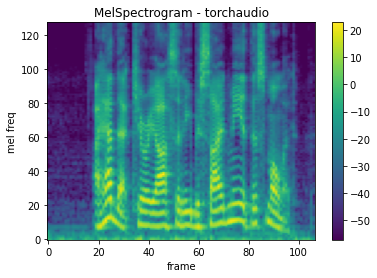

In [8]:
waveform, sample_rate = get_speech_sample()

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

Comparison against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~~

For reference, here is the equivalent means of generating mel-scale
spectrograms with ``librosa``.




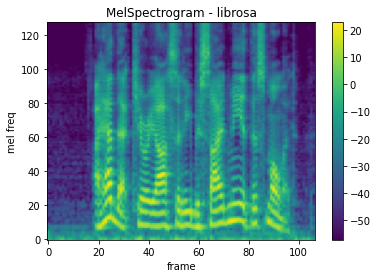

Mean Square Difference:  1.1718387371573158e-10


In [9]:
melspec_librosa = librosa.feature.melspectrogram(
    waveform.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm='slaney',
    htk=True,
)
plot_spectrogram(
    melspec_librosa, title="MelSpectrogram - librosa", ylabel='mel freq')

mse = torch.square(melspec - melspec_librosa).mean().item()
print('Mean Square Difference: ', mse)

MFCC
----




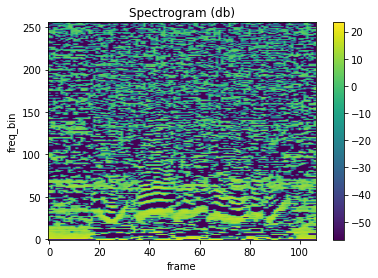

In [10]:
waveform, sample_rate = get_speech_sample()

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

Comparing against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~




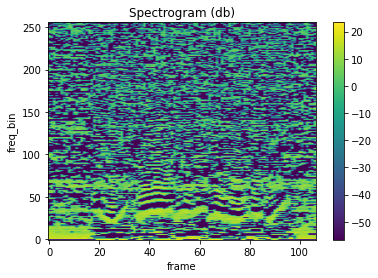

Mean Square Difference:  4.2571510761035825e-08


In [11]:
melspec = librosa.feature.melspectrogram(
  y=waveform.numpy()[0], sr=sample_rate, n_fft=n_fft,
  win_length=win_length, hop_length=hop_length,
  n_mels=n_mels, htk=True, norm=None)

mfcc_librosa = librosa.feature.mfcc(
  S=librosa.core.spectrum.power_to_db(melspec),
  n_mfcc=n_mfcc, dct_type=2, norm='ortho')

plot_spectrogram(mfcc_librosa)

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print('Mean Square Difference: ', mse)

Pitch
-----




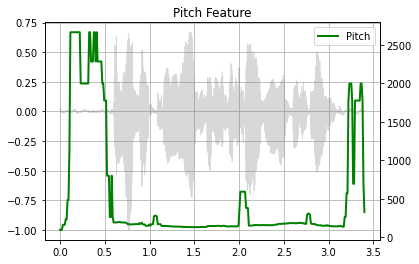

In [12]:
waveform, sample_rate = get_speech_sample()

pitch = F.detect_pitch_frequency(waveform, sample_rate)
plot_pitch(waveform, sample_rate, pitch)
play_audio(waveform, sample_rate)

Kaldi Pitch (beta)
------------------

Kaldi Pitch feature [1] is a pitch detection mechanism tuned for automatic
speech recognition (ASR) applications. This is a beta feature in ``torchaudio``,
and it is available only in ``functional``.

1. A pitch extraction algorithm tuned for automatic speech recognition

   Ghahremani, B. BabaAli, D. Povey, K. Riedhammer, J. Trmal and S.
   Khudanpur

   2014 IEEE International Conference on Acoustics, Speech and Signal
   Processing (ICASSP), Florence, 2014, pp. 2494-2498, doi:
   10.1109/ICASSP.2014.6854049.
   [`abstract <https://ieeexplore.ieee.org/document/6854049>`__],
   [`paper <https://danielpovey.com/files/2014_icassp_pitch.pdf>`__]




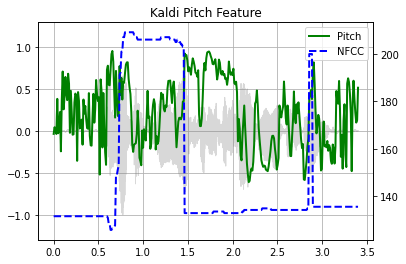

In [13]:
waveform, sample_rate = get_speech_sample(resample=16000)

pitch_feature = F.compute_kaldi_pitch(waveform, sample_rate)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc)
play_audio(waveform, sample_rate)